# データベース検索を行う

ここでは、**グローバーのアルゴリズム**{cite}`grover_search,nielsen_chuang_search`の紹介と、そのアルゴリズムを使用して構造化されていないデータベースを検索する問題を考えます。アルゴリズムを説明した後に、Qiskitを使用してグローバーのアルゴリズムを実装します。

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{| #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 |}$
$\newcommand{\braket}[2]{\langle #1 | #2 \rangle}$

## はじめに

量子コンピュータが古典コンピュータの計算能力を優位に上回る性能を発揮するためには、量子計算の特徴をうまく活用するアルゴリズムを考える必要があります。そのような量子アルゴリズムの一つとして知られているのが、グローバーのアルゴリズムです。このアルゴリズムは**構造化されていないデータベースの検索**に適しており、古典計算より少ない計算量で答えを得られることが証明されています。このアルゴリズムは**振幅増幅**と呼ばれる手法をベースにしており、量子アルゴリズムのサブルーチンとしても幅広く活用されています。

(database)=
## 非構造化データの検索

$N$個の要素からなるリストがあり、その中の一つの要素$w$を見つけたいとします。求める要素$w$を見つけるためには、古典計算では最悪の場合$N$回、平均では$N/2$回リストを調べる必要があります。グローバーのアルゴリズムでは、おおよそ$\sqrt{N}$回の検索で$w$を見つけることができることが知られています。つまり、**古典計算に対して二次の高速化が可能**というわけです。

(grover)=
## グローバーのアルゴリズム

ここでは$n$個の量子ビットを考え、その量子ビットが表現できる可能性のある全ての計算基底でリストが構成されているものとします。つまり$N=2^n$として、リストは$\ket{00\cdots00}$, $\ket{00\cdots01}$, $\ket{00\cdots10}$, $\cdots$, $\ket{11\cdots11}$までの$N$個の要素（10進数表記だと$\ket{0}$, $\ket{1}$, $\cdots$, $\ket{N-1}$）を含んでいます。

(grover_phaseoracle)=
### 位相オラクルの導入

グローバーのアルゴリズムで重要になるのは、特定の状態の位相を変える位相オラクルです。まず、$U\ket{x}=(-1)^{f(x)}\ket{x}$で与えられる位相オラクルを考えます。つまりある状態$\ket{x}$に作用すると、その状態の位相をある関数$f(x)$に応じて$-1^{f(x)}$だけシフトさせるような演算です。ここで$f(x)$として

$$
f(x) = \bigg\{
\begin{aligned}
&1 \quad \text{if} \; x = w \\
&0 \quad \text{else} \\
\end{aligned}
$$

のような関数を考えると、求める解$w$の位相を反転するオラクル$U_w$

$$
U_w:\begin{aligned}
&\ket{w} \to -\ket{w}\\
&\ket{x} \to \ket{x} \quad \forall \; x \neq w
\end{aligned}
$$

が得られます。この時、$U_w$は$U_w=I-2\ket{w}\bra{ w}$と表現できることが分かります。また、関数$f_0(x)$として

$$
f_0(x) = \bigg\{
\begin{aligned}
&0 \quad \text{if} \; x = 0 \\
&1 \quad \text{else} \\
\end{aligned}
$$

を考えると、0以外の位相を反転するユニタリー$U_0$

$$
U_0:\begin{aligned}
&\ket{0}^{\otimes n} \to \ket{0}^{\otimes n}\\
&\ket{x} \to -\ket{x} \quad \forall \; x \neq 0
\end{aligned}
$$

を得ることができます。この時、$U_0$は$U_0=2\ket{0}\bra{ 0}^{\otimes n}-I$になります。

(grover_circuit)=
### 量子回路の構成

グローバーアルゴリズムを実装する量子回路の構造は、下図のようになっています。$n$量子ビットの回路を$\ket{0}$の初期状態から出発し、Hadamard演算を適用して重ね合わせ状態を作ります。その後、$G$と書かれている演算を繰り返し適用します。

```{image} figs/grover.png
:alt: grover
:class: bg-primary mb-1
:width: 600px
:align: center
```

$G$は「**グローバーの反復**」とも呼ばれるユニタリー演算で、以下のような4つのステップから構成されています。

```{image} figs/grover_iter.png
:alt: grover_iter
:class: bg-primary mb-1
:width: 550px
:align: center
```

$U_w$と$U_0$は、それぞれ上で説明した解$w$の位相を反転するオラクルと0以外の位相を反転するオラクルです。

回路の最初にあるHadamard演算と合わせて、グローバーの反復を1回実行するまでのステップ

```{image} figs/grover_iter1.png
:alt: grover_iter1
:class: bg-primary mb-1
:width: 600px
:align: center
```

を細かく見ていきます。

(grover_superposition)=
### 重ね合わせ状態の生成
まず、$n$量子ビット回路の初期状態$\ket{0}^{\otimes n}$にHadamard演算を適用し、一様に重ね合わされた状態を生成します。

$$
\ket{s} = H^{\otimes n}\ket{0}^{\otimes n} = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}\ket{x}
$$

この状態を$\ket{s}$とします。

(grover_geometry)=
### 幾何学的な表現
この$\ket{s}$の状態を幾何学的に表現してみましょう。まず、重ね合わせ状態$\ket{s}$と求める状態$\ket{w}$が張る2次元平面を考えます。$\ket{w}$に直交する状態$\ket{w^{\perp}}$は$\ket{w^{\perp}}:=\frac{1}{\sqrt{N-1}}\sum_{x \neq w}\ket{x}$と表現できるため、この平面上では$\ket{w}$に直交する軸に相当します。簡易的に、この平面では$\ket{w^{\perp}}=\begin{bmatrix}1\\0\end{bmatrix}$と$\ket{w}=\begin{bmatrix}0\\1\end{bmatrix}$と書くことにします。

まとめると、この2次元平面では$\ket{s}$は($\ket{w^{\perp}}$, $\ket{w}$)という二つのベクトルの線形和として書くことができます。

$$
\begin{aligned}
\ket{s}&=\sqrt{\frac{N-1}{N}}\ket{w^{\perp}}+\frac1{\sqrt{N}}\ket{w}\\
&=: \cos\frac\theta2\ket{w^{\perp}}+\sin\frac\theta2\ket{w}\\
&= \begin{bmatrix}\cos\frac\theta2\\\sin\frac\theta2\end{bmatrix}
\end{aligned}
$$

答えが一つであるため、$\ket{w}$の振幅は$\frac1{\sqrt{N}}$、$\ket{w^{\perp}}$の振幅は$\sqrt{\frac{N-1}{N}}$になります。$\sin\frac\theta2=\frac1{\sqrt{N}}$なる$\theta$を定義すると、

$$
\theta=2\arcsin\frac{1}{\sqrt{N}}
$$

になります。($\ket{w^{\perp}}$, $\ket{w}$)平面での$\ket{s}$を図示すると、以下のようになります。

```{image} figs/grover_rot1.png
:alt: grover_rot1
:class: bg-primary mb-1
:width: 300px
:align: center
```

(grover_oracle)=
### オラクルの適用
次に、$\ket{s}$にオラクル$U_w$を適用します。このオラクルは、この平面上では$U_w=I-2\ket{w}\bra{ w}=\begin{bmatrix}1&0\\0&-1\end{bmatrix}$と表現することが可能です。つまり、$U_w$は$\ket{w^{\perp}}$軸に関して$\ket{s}$を折り返す操作（下図）に対応しており、この操作で$\ket{w}$の位相が反転します。

```{image} figs/grover_rot2.png
:alt: grover_rot2
:class: bg-primary mb-1
:width: 300px
:align: center
```

(grover_diffuser)=
### Diffuserの適用
次は$H^{\otimes n}U_0H^{\otimes n}$の適用で、この演算はDiffuserと呼ばれます。$U_0=2\ket{0}\bra{0}^{\otimes n}-I$なので、$U_s \equiv H^{\otimes n}U_0H^{\otimes n}$と定義すると

$$
\begin{aligned}
U_s &\equiv H^{\otimes n}U_0H^{\otimes n}\\
&=2H^{\otimes n}\ket{0}^{\otimes n}\bra{0}^{\otimes n}H^{\otimes n}-H^{\otimes n}H^{\otimes n}\\
&=2\ket{s}\bra{ s}-I\\
&=\begin{bmatrix}\cos\theta&\sin\theta\\\sin\theta&-\cos\theta\end{bmatrix}
\end{aligned}
$$

になります。つまり、Diffuser$U_s$は$U_w\ket{s}$を$\ket{s}$に関して折り返す操作に対応します（下図）。

```{image} figs/grover_rot3.png
:alt: grover_rot3
:class: bg-primary mb-1
:width: 300px
:align: center
```

まとめると、グローバーの反復$G=U_sU_w$は

$$
\begin{aligned}
G&=U_sU_w\\
&= \begin{bmatrix}\cos\theta&-\sin\theta\\\sin\theta&\cos\theta\end{bmatrix}
\end{aligned}
$$

であるため、$\ket{s}$を$\ket{w}$に向けて角度$\theta$だけ回転する操作を表していることが分かります（下図）。

```{image} figs/grover_rot4.png
:alt: grover_rot4
:class: bg-primary mb-1
:width: 300px
:align: center
```

$G$を1回適用すれば$\theta$だけ回転するということは、$G$を$r$回繰り返せば$r\theta$回転することになります。その時の$\ket{s}$の状態は

$$
G^r\ket{s}=\begin{bmatrix}\cos\frac{2r+1}{2}\theta\\\sin\frac{2r+1}{2}\theta\end{bmatrix}
$$

で与えられます。つまり、求める答え$\ket{w}$に到達するためには、$\frac{2r+1}2\theta\approx\frac{\pi}2$となる$r$の回数だけ回転すれば良いことになります。
1回の回転角$\theta$が十分小さいとして、$\sin\frac\theta2=\frac{1}{\sqrt{N}}\approx\frac\theta2$とすると、$r\approx\frac\pi4\sqrt{N}$が得られます。つまり${\cal O}(\sqrt{N})$の操作で答え$\ket{w}$に到達することが示せたわけであり、古典計算に対する2次の高速化が得られることが分かりました。

Diffuserの役割をもう少し見てみましょう。ある状態$\ket{\psi}$が、$\ket{\psi}:=\sum_k a_k\ket{k}$という振幅$a_k$を持つ$\ket{k}$の重ね合わせ状態として書かれるとしましょう。この状態にDiffuserを適用すると

$$
\begin{aligned}
\left( 2\ket{s}\bra{ s} - I \right)\ket{\psi}&=\frac2N\sum_i\ket{i}\cdot\sum_{j,k}a_k\braket{j}{k}-\sum_k a_k\ket{k}\\
&= 2\frac{\sum_i a_i}{N}\sum_k\ket{k}-\sum_k a_k\ket{k}\\
&= \sum_k \left( 2\langle a \rangle-a_k \right)\ket{k}
\end{aligned}
$$

となります。$\langle a \rangle\equiv\frac{\sum_i a_i}{N}$は振幅の平均です。この式が意味するところは、ある状態$\ket{k}$の振幅$a_k$が、平均に対する摂動の形$a_k=\langle a \rangle-\Delta$で表現できると考えると理解しやすくなります。つまり、Diffuserを適用した後の振幅が$2\langle a \rangle-a_k=\langle a \rangle+\Delta$になることから、Diffuserは平均$\langle a \rangle$に関して振幅を反転する操作を表していると考えることができるわけです。

(grover_amp)=
### 振幅増幅を可視化する
グローバーアルゴリズムで振幅がどのように増幅されるのか、実際目で見てみることにします。

まず最初のHadamard変換で、全ての計算基底が等しい振幅を持つ重ね合わせ状態を生成します（下図の1）。横軸は$N$個の計算基底、縦軸は各基底の振幅の大きさを表しており、全ての基底が$\frac{1}{\sqrt{N}}$の大きさの振幅を持っています（振幅の平均を赤破線で表示）。

次にオラクル$U_w$を適用すると、$\ket{w}$の位相が反転し、振幅が$-\frac{1}{\sqrt{N}}$になります（下図の2）。この状態での振幅の平均は$\frac{1}{\sqrt{N}}(1-\frac2N)$になり、(1)の状態より低くなります。

最後にDiffuserを適用すると、平均に関して振幅を反転します（下図の3）。その結果、$\ket{w}$の振幅が増幅され、$\ket{w}$以外の基底の振幅は減少します。1回のグローバーの反復操作で、$\ket{w}$の振幅が約3倍程度増幅することも図から見てとれます。この操作を繰り返し実行すれば$\ket{w}$の振幅がさらに増幅されるため、正しい答えを得る確率が増加していくだろうということも予想できますね。

```{image} figs/grover_amp.png
:alt: grover_amp
:class: bg-primary mb-1
:width: 800px
:align: center
```

(grover_multidata)=
### 複数データの検索
今までは検索するデータが一つだけの場合を考えてきましたが、このセクションの最後に複数のデータを検索する場合を考察してみましょう。例えば、$N=2^n$個のデータから$M$個のデータ$\{w_i\}\;(i=0,1,\cdots,M-1)$を探すケースです。これまでと同様に、求める状態$\ket{w}$とそれに直行する状態$\ket{w^{\perp}}$

$$
\begin{aligned}
&\ket{w}:=\frac{1}{\sqrt{M}}\sum_{i=0}^{M-1}\ket{w_i}\\
&\ket{w^{\perp}}:=\frac{1}{\sqrt{N-M}}\sum_{x\notin\{w_0,\cdots,w_{M-1}\}}\ket{x}
\end{aligned}
$$

が張る2次元平面の上で、同様の議論を進めることができます。$\ket{s}$はこの平面上で

$$
\begin{aligned}
\ket{s}&=\sqrt{\frac{N-M}{N}}\ket{w^{\perp}}+\sqrt{\frac{M}{N}}\ket{w}\\
&=: \cos\frac\theta2\ket{w^{\perp}}+\sin\frac\theta2\ket{w}\\
\end{aligned}
$$

と表現でき、$\ket{w}$の振幅$\sqrt{\frac{M}{N}}$を$\sin\frac\theta2$と定義すると、角度$\theta$は$\theta=2\arcsin\sqrt{\frac{M}{N}}$になります。答えが一つのケースと比べて、角度は$\sqrt{M}$倍大きく、1回のグローバーの反復操作でより大きく回転することになります。その結果、より少ない$r\approx\frac\pi4\sqrt{\frac{N}{M}}$回の回転操作で答えに到達することが可能になることが分かります。

(imp)=
## アルゴリズムの実装（$N=2^6$の場合）
ではここから、実際にグローバーアルゴリズムを実装してデータベースの検索問題に取り掛かってみましょう。

ここで考える問題は、$N=2^6$個の要素を持つリスト（$=[0,1,2,\cdots,63]$）から、一つの答え"45"を見つけるグローバーアルゴリズムの実装です（もちろんこの数はなんでも良いので、後で自由に変更して遊んでみてください）。つまり6量子ビットの量子回路を使って、$\ket{45}=\ket{101101}$を探す問題です。

(imp_qiskit)=
### Qiskitでの実装

まず必要な環境をセットアップします。

In [1]:
# Tested with python 3.8.12, qiskit 0.34.2, numpy 1.22.2
import matplotlib.pyplot as plt
import numpy as np

# Qiskit関連のパッケージをインポート
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.providers.ibmq import least_busy, IBMQAccountCredentialsNotFound
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

# ワークブック独自のモジュール
from qc_workbook.utils import operational_backend

6量子ビットの回路`grover_circuit`を準備します。

グローバー反復を一回実行する量子回路は以下のような構成になりますが、赤枠で囲んだ部分（オラクルとDiffuserの中の$2\ket{0}\bra{0}-I$の部分）を実装する量子回路を書いてください。

```{image} figs/grover_6bits_45.png
:alt: grover_6bits_45
:class: bg-primary mb-1
:width: 600px
:align: center
```

一様な重ね合わせ状態$\ket{s}$を生成した後に、オラクルを実装します。

In [2]:
def initialize_s(qc, qubits):
    """回路のqubitsにHゲートを適用"""
    for q in qubits:
        qc.h(q)
    return qc

Nsol = 45
n = 6
grover_circuit = QuantumCircuit(n)

grover_circuit = initialize_s(grover_circuit, list(range(n)))

# オラクルを作成して、回路に実装
oracle = QuantumCircuit(n)

##################
### EDIT BELOW ###
##################

#oracle.?

##################
### EDIT ABOVE ###
##################

oracle_gate = oracle.to_gate()
oracle_gate.name = "U_w"
print(oracle)

grover_circuit.append(oracle_gate, list(range(n)))

     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     
q_5: 
     


次に、Diffuser用の回路を実装します。

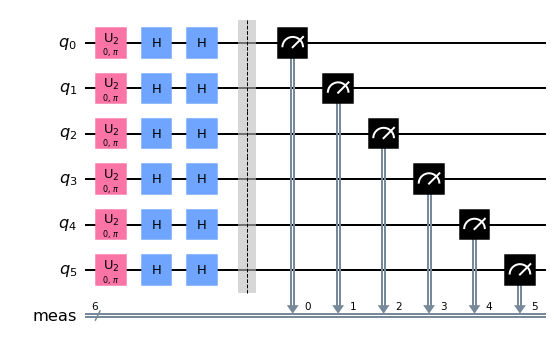

In [3]:
def diffuser(n):
    qc = QuantumCircuit(n)

    qc.h(range(n))

    ##################
    ### EDIT BELOW ###
    ##################

    #qc.?

    ##################
    ### EDIT ABOVE ###
    ##################
    
    qc.h(range(n))

    #print(qc)
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

grover_circuit.append(diffuser(n), list(range(n)))
grover_circuit.measure_all()
grover_circuit.decompose().draw('mpl')

(imp_simulator)=
### シミュレータでの実験

回路の実装ができたら、シミュレータで実行して結果をプロットしてみます。結果が分かりやすくなるように、測定したビット列を整数にしてからプロットするようにしてみます。

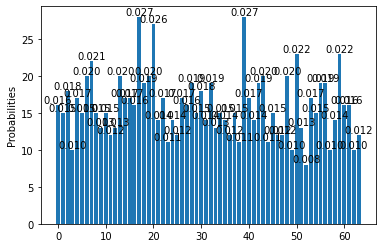

In [4]:
simulator = Aer.get_backend('qasm_simulator')
grover_circuit = transpile(grover_circuit, backend=simulator)
results = simulator.run(grover_circuit, shots=1024).result()
answer = results.get_counts()

# 横軸を整数でプロットする
def show_distribution(answer):
    n = len(answer)
    x = [int(key,2) for key in list(answer.keys())]
    y = list(answer.values())

    fig, ax = plt.subplots()
    rect = ax.bar(x,y)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.3f}'.format(height/sum(y)),
                        xy=(rect.get_x()+rect.get_width()/2, height),xytext=(0,0),
                        textcoords="offset points",ha='center', va='bottom')
    autolabel(rect)
    plt.ylabel('Probabilities')
    plt.show()

show_distribution(answer)

正しく回路が実装できていれば、$\ket{101101}=\ket{45}$の状態を高い確率で測定できる様子を見ることができるでしょう。

しかし、上での議論からも分かるように、$N=2^6$の探索では、一回のグローバー反復では正しくない答えも無視できない確率で現れてきます。グローバーの反復を複数回繰り返すことで、正しい答えがより高い確率で得られることをこの後見ていきます。

(imp_qc)=
### 量子コンピュータでの実験

反復を繰り返す前に、まずは一回のグローバー反復を量子コンピュータで実行してみましょう。

In [5]:
# 量子コンピュータで実行する場合
try:
    IBMQ.load_account()
except IBMQAccountCredentialsNotFound:
    IBMQ.enable_account('__paste_your_token_here__')

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

backend_list = provider.backends(filters=operational_backend(min_qubits=6))
backend = least_busy(backend_list)
print("least busy backend: ", backend)

RequestsApiError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [6]:
# 最も空いているバックエンドで回路を実行します。キュー内のジョブの実行をモニターします。

grover_circuit = transpile(grover_circuit, backend=backend, optimization_level=3)
job = backend.run(grover_circuit, shots=1024)
job_monitor(job, interval=2)

NameError: name 'backend' is not defined

In [7]:
# 計算結果
results = job.result()
answer = results.get_counts(grover_circuit)
show_distribution(answer)

NameError: name 'job' is not defined

シミュレータに比べると結果は非常に悪いですね。。。残念ながら、今の量子コンピュータをそのまま使うとこういう結果になってしまいます。しかし、{ref}`エラー緩和 <measurement_error_mitigation>`等のテクニックを使うことである程度改善することはできます。

(imp_simulator_amp)=
### 振幅増幅を確認する

では次に、グローバーのアルゴリズムを繰り返し使うことで、振幅が増幅していく様子をシミュレータを使って見てみましょう。

例として、上で作ったグローバー反復を3回実行する量子回路を作って実行してみます。

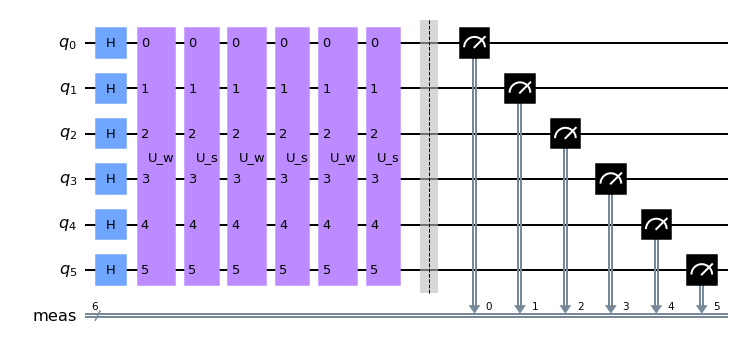

In [8]:
# 繰り返しの回数
Niter = 3

grover_circuit_iterN = QuantumCircuit(n)
grover_circuit_iterN = initialize_s(grover_circuit_iterN, list(range(n)))
for I in range(Niter):
    grover_circuit_iterN.append(oracle_gate, list(range(n)))
    grover_circuit_iterN.append(diffuser(n), list(range(n)))
grover_circuit_iterN.measure_all()
grover_circuit_iterN.draw('mpl')

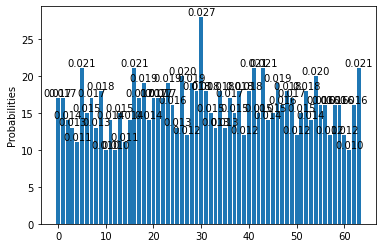

In [9]:
grover_circuit_iterN_tr = transpile(grover_circuit_iterN, backend=simulator)
results = simulator.run(grover_circuit_iterN_tr, shots=1024).result()
answer = results.get_counts()
show_distribution(answer)

正しい答え$\ket{45}$をより高い確率で測定できていることが分かりますね。

では次に、実装した回路を繰り返し実行して、求める解を観測した回数と反復した回数との相関関係を図にしてみます。

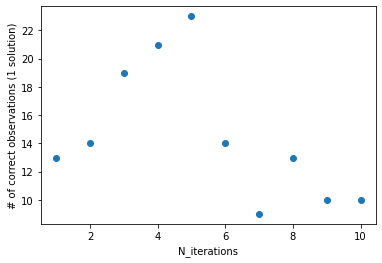

In [10]:
x = []
y = []

# 例えば10回繰り返す
for Niter in range(1,11):
    grover_circuit_iterN = QuantumCircuit(n)
    grover_circuit_iterN = initialize_s(grover_circuit_iterN, list(range(n)))
    for I in range(Niter):
        grover_circuit_iterN.append(oracle_gate, list(range(n)))
        grover_circuit_iterN.append(diffuser(n), list(range(n)))
    grover_circuit_iterN.measure_all()
    #print(grover_circuit_iterN)

    grover_circuit_iterN_tr = transpile(grover_circuit_iterN, backend=simulator)
    results = simulator.run(grover_circuit_iterN_tr, shots=1024).result()
    answer = results.get_counts()
    #show_distribution(answer)

    x.append(Niter)
    y.append(answer[format(Nsol,'06b')])

plt.clf()
plt.scatter(x,y)
plt.xlabel('N_iterations')
plt.ylabel('# of correct observations (1 solution)')
plt.show()

この図から、グローバー反復を5~6回程度繰り返すことで、正しい答えを最も高い確率で測定できることが分かりますね。計算で求めた検索に必要な反復回数と一致しているかどうか、確認してみてください。

問題：解が一つの場合で、探索リストのサイズを$N=2^4$から$N=2^{10}$まで変えた時に、測定で求めた最適な反復回数が$N$とどういう関係になっているのか調べてください。

(imp_simulator_multi)=
### 複数解の探索の場合

では次に、複数の解を探索する問題に進んでみましょう。2つの整数$x_1$と$x_2$を見つける問題へ量子回路を拡張して、求める解を観測した回数と反復した回数との相関関係を図にしてみます。

例えば、$x_1=45$と$x_2=26$の場合は

               ┌───┐               ┌───┐     
q_0: ───────■──┤ X ├────────────■──┤ X ├─────
     ┌───┐  │  ├───┤            │  └───┘     
q_1: ┤ X ├──■──┤ X ├────────────■────────────
     └───┘  │  ├───┤            │  ┌───┐     
q_2: ───────■──┤ X ├────────────■──┤ X ├─────
            │  └───┘            │  └───┘     
q_3: ───────■───────────────────■────────────
     ┌───┐  │  ┌───┐            │            
q_4: ┤ X ├──■──┤ X ├────────────■────────────
     ├───┤┌─┴─┐├───┤┌───┐┌───┐┌─┴─┐┌───┐┌───┐
q_5: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘


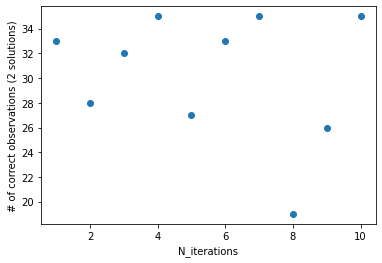

In [11]:
N1 = 45
N2 = 26

oracle_2sol = QuantumCircuit(n)

# 45
oracle_2sol.x(1)
oracle_2sol.x(4)
oracle_2sol.h(n-1)
oracle_2sol.mct(list(range(n-1)), n-1)
oracle_2sol.h(n-1)
oracle_2sol.x(1)
oracle_2sol.x(4)

# 26
oracle_2sol.x(0)
oracle_2sol.x(2)
oracle_2sol.x(5)
oracle_2sol.h(n-1)
oracle_2sol.mct(list(range(n-1)), n-1)
oracle_2sol.h(n-1)
oracle_2sol.x(0)
oracle_2sol.x(2)
oracle_2sol.x(5)

oracle_2sol_gate = oracle_2sol.to_gate()
oracle_2sol_gate.name = "U_w(2sol)"
print(oracle_2sol)

x = []
y = []
for Niter in range(1,11):
    grover_circuit_2sol_iterN = QuantumCircuit(n)
    grover_circuit_2sol_iterN = initialize_s(grover_circuit_2sol_iterN, list(range(n)))
    for I in range(Niter):
        grover_circuit_2sol_iterN.append(oracle_2sol_gate, list(range(n)))
        grover_circuit_2sol_iterN.append(diffuser(n), list(range(n)))
    grover_circuit_2sol_iterN.measure_all()
    #print('-----  Niter =',Niter,' -----------')
    #print(grover_circuit_2sol_iterN)

    grover_circuit_2sol_iterN_tr = transpile(grover_circuit_2sol_iterN, backend=simulator)
    results = simulator.run(grover_circuit_2sol_iterN_tr, shots=1024).result()
    answer = results.get_counts()
    #show_distribution(answer)

    x.append(Niter)
    y.append(answer[format(N1,'06b')]+answer[format(N2,'06b')])

plt.clf()
plt.scatter(x,y)
plt.xlabel('N_iterations')
plt.ylabel('# of correct observations (2 solutions)')
plt.show()

複数解の場合、確率が最大になる反復回数が単一解の場合より減っていますね。予想と合っているでしょうか？

## 参考文献

```{bibliography}
:filter: docname in docnames
```